# Анализ бизнес-показателей развлекательного приложения

В моем распоряжении данные развлекательного приложения ProcrastinatePro+  
Компания вкладывается в рекламу, но последние месяцы терпит убытки.  
**Цель анализа:** выявить причины падения выручки и дать рекомендации бизнесу.

У меня есть данные о пользователях и о компании за период с 1 мая по 27 октября 2019 года, именно:
- логи с сервера с данным о посещениях  
- данные о покупках  
- рекламные расходы  

Работа пройдет в несколько этапов.  
**Шаг 1.** Изучу данные и подготовлю их к анализу.  
**Шаг 2.** Задам функции для расчета бизнес-показателей (LTV, ROI, коэф. удержания и конверсии)  
**Шаг 3.** Проведу исследовательский анализ данных.  
*Изучу:*  
откуда приходят пользователи и какими устройствами они пользуются;  
распределение платящих и неплатящих пользователей;  
определю каналы, из которых приходит больше платящих пользователей.  
**Шаг 4.** Оценю маркетинговые мероприятия  
Оценю траты, их распределение по времени и посчитаю CAC (customer attraction cost) для каждого источника.  
**Шаг 5.** Оценю окупаемость рекламы  
С разбивкой по разным факторам оценю окупаемость. А также посмотрю на удержание и конверсию пользователей.

Перед тем как приступить к работе - загружу библиотеки, которые понадобятся в работе.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, date
import numpy as np

### Знакомство с данными и предобработка

В переменные сохраню данные о визитах, покупках и рекламных расходах.

In [2]:
visits = pd.read_csv(r'C:\Users\HOME\Desktop\Practicum\datasets\fin_analysis\visits_info_short.csv')
orders = pd.read_csv(r'C:\Users\HOME\Desktop\Practicum\datasets\fin_analysis\orders_info_short.csv')
promo = pd.read_csv(r'C:\Users\HOME\Desktop\Practicum\datasets\fin_analysis\costs_info_short.csv')

Познакомлюсь с данными:

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [5]:
promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


В данных нет пропусков. Это хорошо.  
Для дальнейшего удобства переименую столбцы данных и приведу их к одному стилю

In [6]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders = orders.rename(columns={'User Id':'user_id', 'Event Dt':'event_dt', 'Revenue':'revenue'})
promo = promo.rename(columns={'Channel':'channel'})

Проверю данные на наличие дубликатов

In [7]:
print('Кол-во дубликатов в visits',
      visits.duplicated(subset=['user_id', 'session_start']).sum())
print('Кол-во дубликатов в orders',
      orders.duplicated().sum())
print('Кол-во дубликатов в promo',
      promo.duplicated().sum())

Кол-во дубликатов в visits 0
Кол-во дубликатов в orders 0
Кол-во дубликатов в promo 0


Дубликатов тоже нет. Тогда осталось только привести данные к нужным форматам.

In [8]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

promo['dt'] = pd.to_datetime(promo['dt'])

Исходные данные качественны. Дубликаты отсутствуют, форматы соответствуют ожидаемым.

Посмотрю, как выглядят данные.

In [9]:
display(visits.head(3))
display(orders.head(3))
promo.head(3)

user_id         region  device  channel       session_start  \
0  981449118918  United States  iPhone  organic 2019-05-01 02:36:01   
1  278965908054  United States  iPhone  organic 2019-05-01 04:46:31   
2  590706206550  United States     Mac  organic 2019-05-01 14:09:25   

          session_end  
0 2019-05-01 02:45:01  
1 2019-05-01 04:47:35  
2 2019-05-01 15:32:08

user_id            event_dt  revenue
0  188246423999 2019-05-01 23:09:52     4.99
1  174361394180 2019-05-01 12:24:04     4.99
2  529610067795 2019-05-01 11:34:04     4.99

dt   channel  costs
0 2019-05-01  FaceBoom  113.3
1 2019-05-02  FaceBoom   78.1
2 2019-05-03  FaceBoom   85.8

### Определение необходимых функций

Для дальнейших расчетов понадобится множество функций.  
Определю их прежде чем проводить анализ.

Задам функцию `get_profiles` для создания профилей пользователей

In [10]:
def get_profiles(visits, orders, promo):
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )
    new_users['dt'] = pd.to_datetime(new_users['dt'])
    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = promo.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    profiles['dt'] = pd.to_datetime(profiles['dt'])
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['month'] = profiles['month'].dt.month
    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Функцию `get_retention` для подсчета коэффициента удержания

In [11]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Функцию `get_conversion` для расчета конверсии

In [12]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

А также функцию `get_ltv` для расчета life-time value пользователей и ROI

In [13]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Функция для сглаживания датафреймов.

In [14]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

Определю функцию для графиков LTV и ROI.

In [15]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Функцию для визуализации удержания.

In [16]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

И для визуализации конверсии

In [17]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

#### Профили пользователей

Построю графики, чтобы увидеть количество новых пользователей по месяцам и сумму расходов на рекламу каждый месяц.  
Предварительно применю функцию `get_profiles`, чтобы выделить новых пользователей и информацию об их первых посещениях.

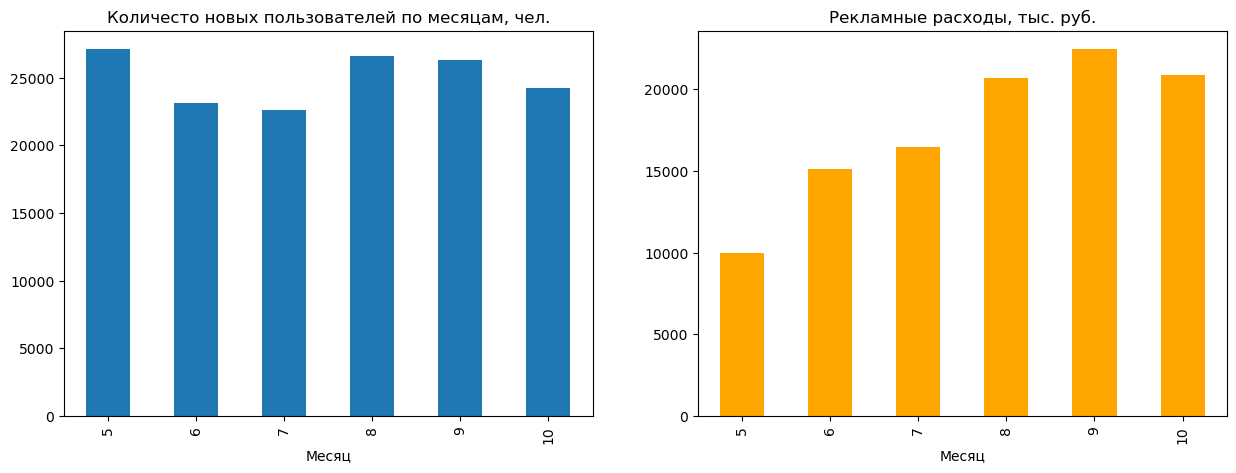

In [24]:
profiles = get_profiles(visits, orders, promo)
plt.figure(figsize=(15, 5))

(profiles
 .groupby('month')
 .agg({'user_id':'count'})
 .plot(kind='bar', legend=False, ax=plt.subplot(1,2,1)))
plt.title('Количесто новых пользователей по месяцам, чел.')
plt.xlabel('Месяц')

promo['month'] = promo['dt'].dt.month
(promo.pivot_table(index='month', values='costs', aggfunc='sum')
      .plot(kind='bar', legend=False, ax=plt.subplot(1,2,2), color='orange'))
plt.title('Рекламные расходы, тыс. руб.')
plt.xlabel('Месяц');

In [25]:
print('Первая реклама за период', promo['dt'].dt.date.min(), '\n'
      'Последняя реклама за период', promo['dt'].dt.date.max())

Первая реклама за период 2019-05-01 
Последняя реклама за период 2019-10-27


Компания ведет активную рекламную политику. Уже сейчас видно высокую цену привлечения пользователя (CAC).  
Любопытно, что постоянное продвижение и увеличение рекламных расходов не приводит к росту числа новых пользователей.  
Почему так - предстоит разобраться дальше.

#### Географическое распределение

Посмотрю пользователей по странам: общее количество пользователей, плательщиков и долю плательщиков от общего числа.

In [26]:
regoin_profiles = profiles.groupby('region').agg({'user_id':'count', 'payer':'mean'})
regoin_profiles['payer'] = round(regoin_profiles['payer']*100, 2)
regoin_profiles = regoin_profiles.rename(columns={'user_id':'users_amount', 'payer':'payers_prc'})
regoin_profiles.sort_values(by='payers_prc', ascending=False)

users_amount  payers_prc
region                                 
United States        100002        6.90
Germany               14981        4.11
UK                    17575        3.98
France                17450        3.80

Больше всего пользователей и плательщиков в США. Меньше всего доля плательщиков во Франции.  
Средняя доля плательщиков - 4.7%

#### Какими устройствами пользуются клиенты

In [27]:
device_profiles = profiles.groupby('device').agg({'user_id':'count', 'payer':'mean'})
device_profiles['payer'] = round(device_profiles['payer']*100, 2)
device_profiles = device_profiles.rename(columns={'user_id':'users_amount', 'payer':'payers_prc'})
device_profiles.sort_values(by='payers_prc', ascending=False)

users_amount  payers_prc
device                           
Mac             30042        6.36
iPhone          54479        6.21
Android         35032        5.85
PC              30455        5.05

Пользователи чаще пользуются мобильными устройствами для пользования сервисом. 36% пользователей пользуется iPhone, 23% пользуются Android-устройствами, и оставшаяся часть пользуется поровну либо PC, либо Mac.  
Больше всего платящих пользователей пользуются платформой Mac и iPhone, чуть реже пользователи Android-смартфонов и еще реже пользователи ПК.

#### Рекламные источники

In [28]:
promo_profiles = profiles.groupby('channel').agg({'user_id':'count', 'payer':'mean'})
promo_profiles['payer'] = round(promo_profiles['payer']*100, 2)
promo_profiles = promo_profiles.rename(columns={'user_id':'users_amount', 'payer':'payers_prc'})
pd.DataFrame(promo_profiles
             .sort_values(by='payers_prc', ascending=False)).style.background_gradient('GnBu').format('{:.1f}')

In [29]:
print('Кол-во не органических пользователей:',
      profiles.query('channel != "organic"')['user_id'].count())

Кол-во не органических пользователей 93569


Большинство пользователей приходит через рекламные каналы.  
93 тысячи против 56 тыс. органических. При этом органические пользователи реже всех являются плательщиками.  
Чаще всего плательщиками становятся пользователи, пришедшие через каналы FaceBoom, AdNonSense, lambdaMediaAds и TipTop.

#### Вывод исследовательского анализа

Рекламные расходы постоянно растут. В мае они составляли 10 000, к июлю выросли уже до 16 447 тысяч, и в октябре вовсе доросли до 20 800.  
При этом количество новых пользователей от месяца к месяцу менялось слабо. В среднем компания привлекала по 16 тыс. новых пользователей ежемесячно.

Больше всего пользователей и плательщиков в США. Меньше всего доля плательщиков во Франции.
Средняя доля плательщиков - 4.7%

6% пользователей пользуется iPhone, 23% пользуются Android-устройствами, и оставшаяся часть пользуется поровну либо PC, либо Mac. Охотнее других пользователей плательщиками становятся пользователи Mac (6.36%) и iPhone (6.21%). От пользователей Android плательщиками являются 5.85%, и реже всех плательщиками становятся пользователи PC (5.05%)

38% пользователей являются органическими и такие пользователи - реже всех становятся плательщиками.  
Больше всего неорганических пользователей пришло из канала FaceBoom (29 тыс.) с 12% плательщиков. 20 тыс. пришло от канала TipTop с 9% плательщиков. Есть каналы, из которых пришло немного пользователей AdNonSense (3.8 тыс.) и lambdaMediaAds (2.1 тыс.), но из этих каналов 10% пользователей становятся плательщиками.

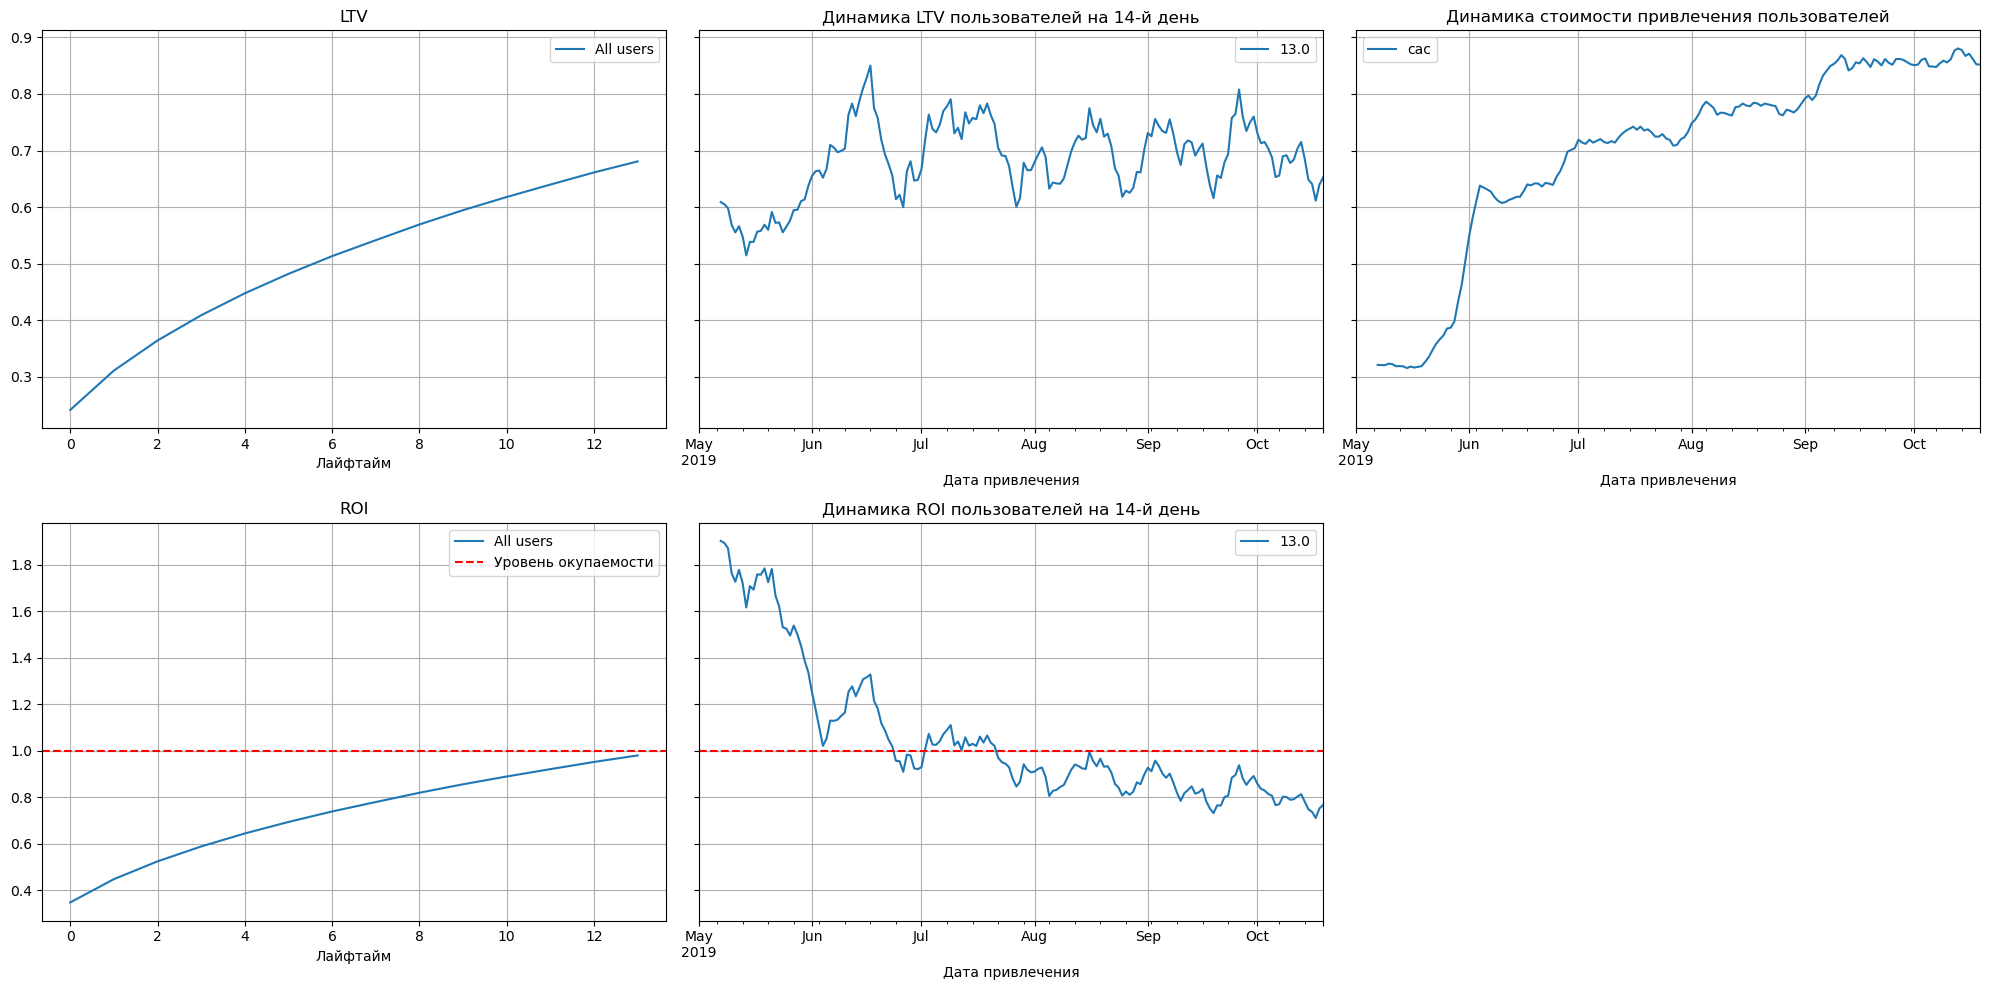

In [31]:
from datetime import datetime, timedelta
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days)
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days)
ltv_raw, ltv_grouped, ltv_history,  roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

### Маркетинг

Посмотрю общую сумму расходов на маркетинг за период с мая по октябрь.

In [37]:
round(promo.costs.sum())

105497

Сумма расходов сравнима с количеством привлеченных пользователей.  
Посмотрю на CAC без разбивки по рекламному каналу.

In [38]:
round(promo.costs.sum()) / profiles.query('channel != "organic"')['user_id'].count()

1.1274781177526745

На привлечение одного пользователя уходит больше доллара.  
Интересно взглянуть на траты по каналам.

#### Рекламные расходы по источникам

In [39]:
(pd.DataFrame(promo.groupby('channel')
              .agg({'costs':'sum'})
              .sort_values(by='costs', ascending=False))
              .style.background_gradient('GnBu')
              .format('{:.2f}'))

Больше всего средств уходит на каналы TipTop и Faceboom.  
Запомню это и обращу внимание на них при расчете CAC и ROI для этих каналов.

#### Рекламные расходы по неделям и месяцам

Посмотрю, как изменялись расходы на рекламу по месяцам и неделям.  
Столбец с номером месяца уже есть в таблице `promo`, добавлю столбец с неделей.

In [40]:
promo['week'] = promo['dt'].dt.isocalendar().week

Построю графики динамики изменения расходов по источникам и по времени

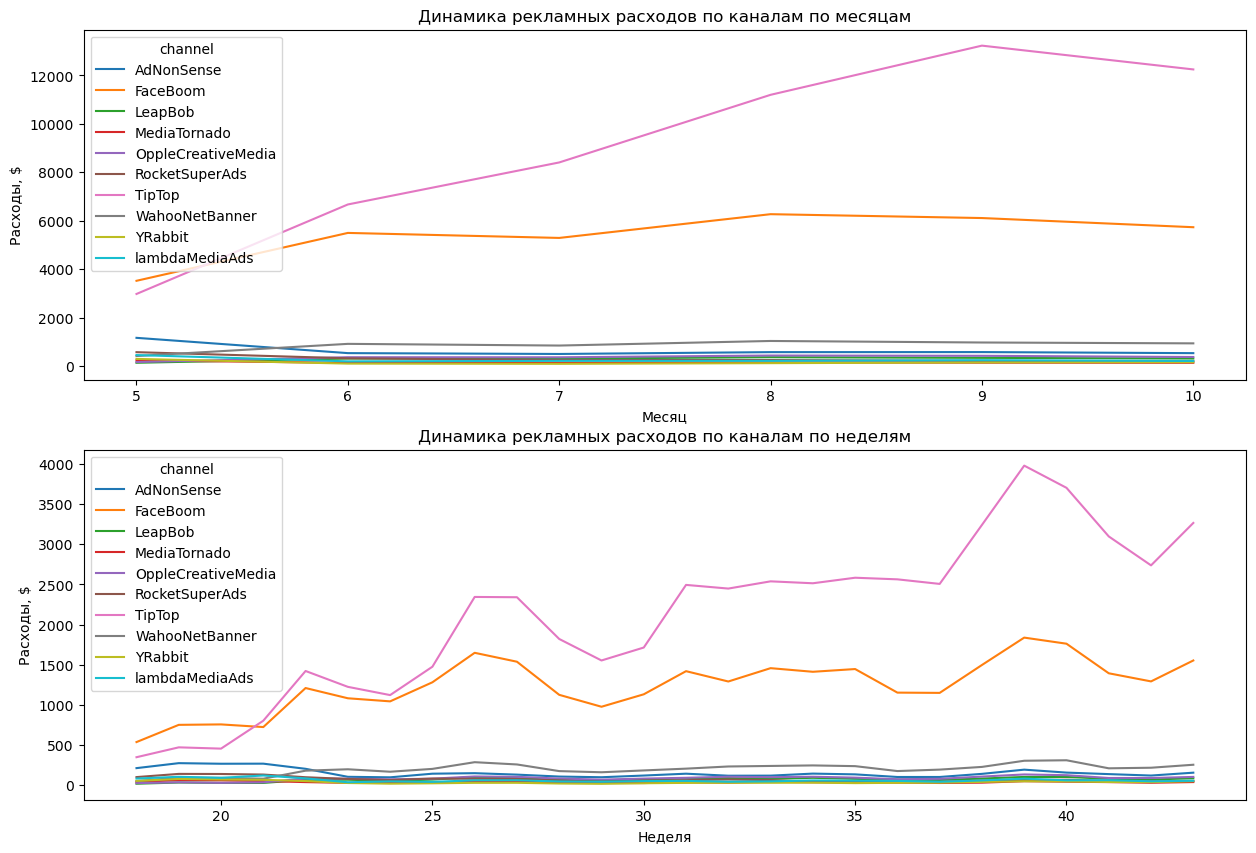

In [41]:
plt.figure(figsize=(15, 10))
#График для разбивки по месяцам
(promo.pivot_table(index='channel', columns='month', values='costs', aggfunc='sum')
      .T.plot(ax=plt.subplot(2,1,1)))
plt.title('Динамика рекламных расходов по каналам по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Расходы, $')
#График для разбивки по неделям
(promo.pivot_table(index='channel', columns='week', values='costs', aggfunc='sum')
      .T.plot(ax=plt.subplot(2,1,2)))
plt.title('Динамика рекламных расходов по каналам по неделям')
plt.xlabel('Неделя')
plt.ylabel('Расходы, $');

На графике видно, что расходы постоянно растут.  
С июня к сентябрю расходы по TipTop вырорсли в два раза.  
Из-за больших расходов на TipTop и FaceBoom плохо проглядывается динамика расходов на другие каналы. Построю для них отдельный график.

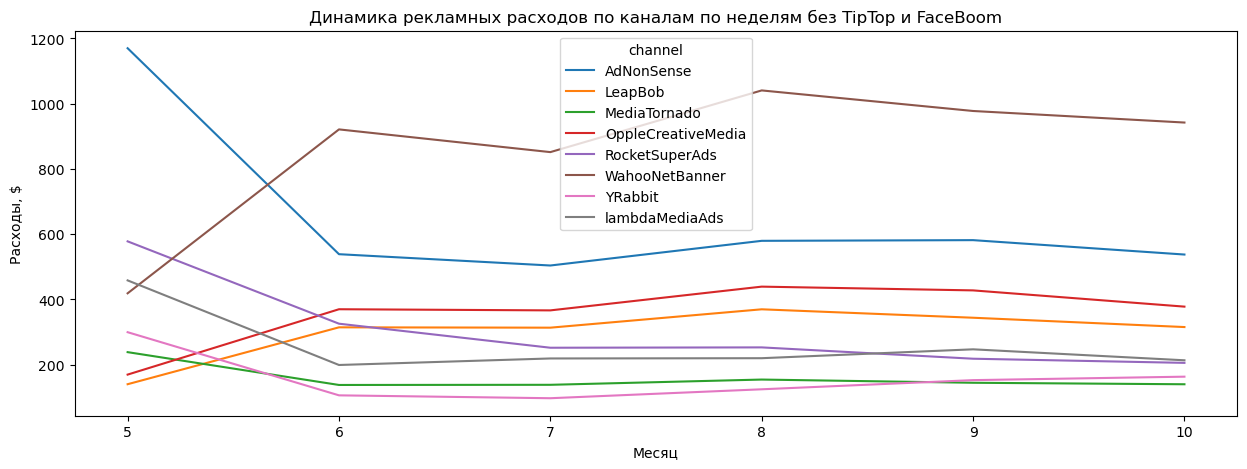

In [42]:
(promo.query('channel != "TipTop" and channel != "FaceBoom"')
      .pivot_table(index='channel', columns='month', values='costs', aggfunc='sum')
      .T.plot(figsize=(15,5)))
plt.title('Динамика рекламных расходов по каналам по неделям без TipTop и FaceBoom')
plt.xlabel('Месяц')
plt.ylabel('Расходы, $');

Расходы на другие каналы же более стабильны и меняются незначительно.

#### Стоимость привлечения клиента по каналам

К таблице `promo_profiles` присоединю данные о расходах на рекламу по каналам, чтобы посчитать CAC.

In [33]:
promo_profiles = promo_profiles.merge(promo.groupby('channel').agg({'costs':'sum'}),
                                      on='channel', how='left')
promo_profiles['cac'] = promo_profiles['costs'] / promo_profiles['users_amount']
pd.DataFrame(promo_profiles
             .drop('organic')
             .sort_values(by='cac', ascending=False)).style.background_gradient('GnBu').format('{:.2f}')

In [39]:
print('Средний CAC:', round(promo_profiles['cac'].mean(), 3))

Средний CAC: 0.756


Стоимость привлечения клиентов у TipTop значительно выше остальных источников.  
При этом в этот канал уходит больше всего средств из рекламного бюджета.  
У FaceBoom и AdNonSense та же ситуцаия - CAC высокий, и средств в них уходит много.  
Скорее всего тут кроется пробелма, связанная с высокими тратами на рекламу.  
Стоит также обратить внимание на каналы, которые приносят больше платящих пользователей, но стоимость привлечения клиента по которым ниже других.

#### Вывод анализа маркетинга

Самые крупные расходы уходят на каналы: TipTop и FaceBoom (по 54 и 32 тыс. соответственно)  

Расходы по этим каналам существенно растут, расходы по TipTop с мая по сентябрь выросли в три раза.  
Средняя CAC по каналам равна 0.76. Этот показатель значительно выше для каналов, на которые идет больший упор в рекламе: 2.8 для TipTop и 1.11 для FaceBoom.

### Оцените окупаемость рекламы

Окупаемость рекламы - важнейший показатель. Изучу его с разных сторон. 

#### CAC, LTV и ROI рекламы

Применю функцию для нахождения CAC профилей и посмотрю на динамику стоимости привлечения пользователей.

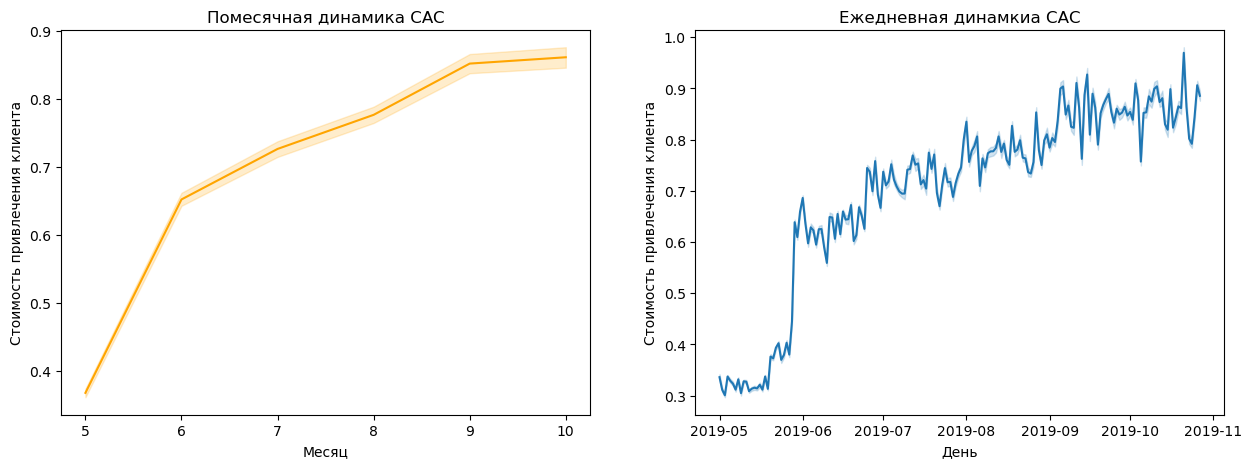

In [40]:
plt.figure(figsize=(15, 5))

#построю график динамики CAC по месяцам
sns.lineplot(data=profiles, x='month', y='acquisition_cost',
             ax=plt.subplot(1,2,1), color='orange')
plt.title('Помесячная динамика CAC')
plt.xlabel('Месяц')
plt.ylabel('Стоимость привлечения клиента')

#Построю график динамики САС по дням, применив скользящее среднее
profiles_cac = profiles.sort_values(by='dt')
profiles_cac['acquisition_cost'] = profiles_cac['acquisition_cost'].rolling(50).mean()
sns.lineplot(data=profiles_cac, x='dt', y='acquisition_cost',
             ax=plt.subplot(1,2,2))
plt.title('Ежедневная динамкиа САС')
plt.xlabel('День')
plt.ylabel('Стоимость привлечения клиента');

Стоимость привлечения пользователей только растет и растет существенно.  
Посмотрю на другие показатели, чтобы оценить эффективна ли рекламная политика.

Представлю, что сегодня 1 ноября 2019 года, возьму эту дату как дату момента анализа.  
По условию, реклама должна окупаться за 14 дней, поэтому за горизонт анализа возьму именно такое количество дней.  
Применю функцию `get_ltv`, чтобы найти ключевые показатели.  
Но перед этим уберу из `profiles` органических пользователей, чтобы анализировать только тех, кто пришел через рекламные каналы.

In [41]:
profiles = profiles.query('channel != "organic"')

In [42]:
 raw_data, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(profiles,
                                                                        orders,
                                                                        date(2019,11,1),
                                                                        14)

Сначала посмотрю на LTV пользователей.

In [43]:
print('\033[1m' + '%55s'%'Таблица LTV по лайфтаймам')
round(ltv_grouped, 2)

                              Таблица LTV по лайфтаймам


cohort_size   0.0   1.0  2.0   3.0   4.0   5.0   6.0   7.0   8.0  \
cohort                                                                        
All users        88644  0.35  0.44  0.5  0.56  0.61  0.65  0.69  0.73  0.76   

           9.0  10.0  11.0  12.0  13.0  
cohort                                  
All users  0.8  0.83  0.85  0.88   0.9

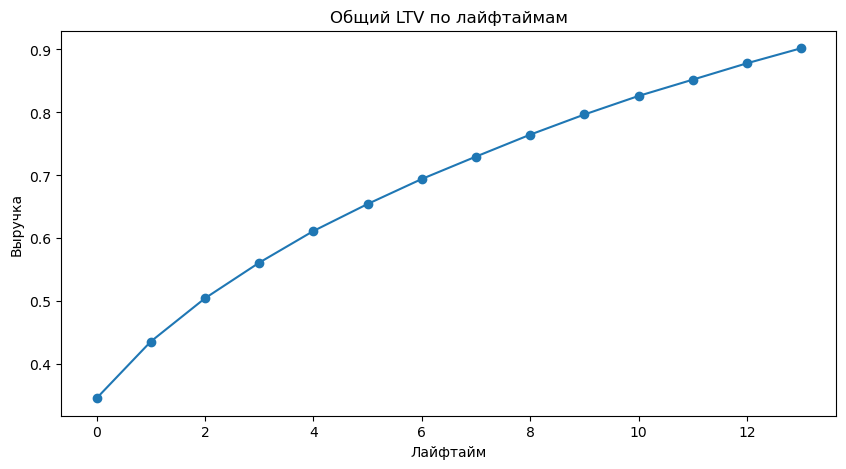

In [44]:
ltv_grouped.drop(columns='cohort_size').T.plot(style='o-',
                                               legend=False,
                                               figsize=(10,5))
plt.title('Общий LTV по лайфтаймам')
plt.xlabel('Лайфтайм')
plt.ylabel('Выручка');

Выручка от клиента, которую получает компания в первые 14 дней пользования приложением, ожидаемо растет.  
Но LTV сравним с CAC, что не очень хорошо.

Посмотрю на ROI рекламы.

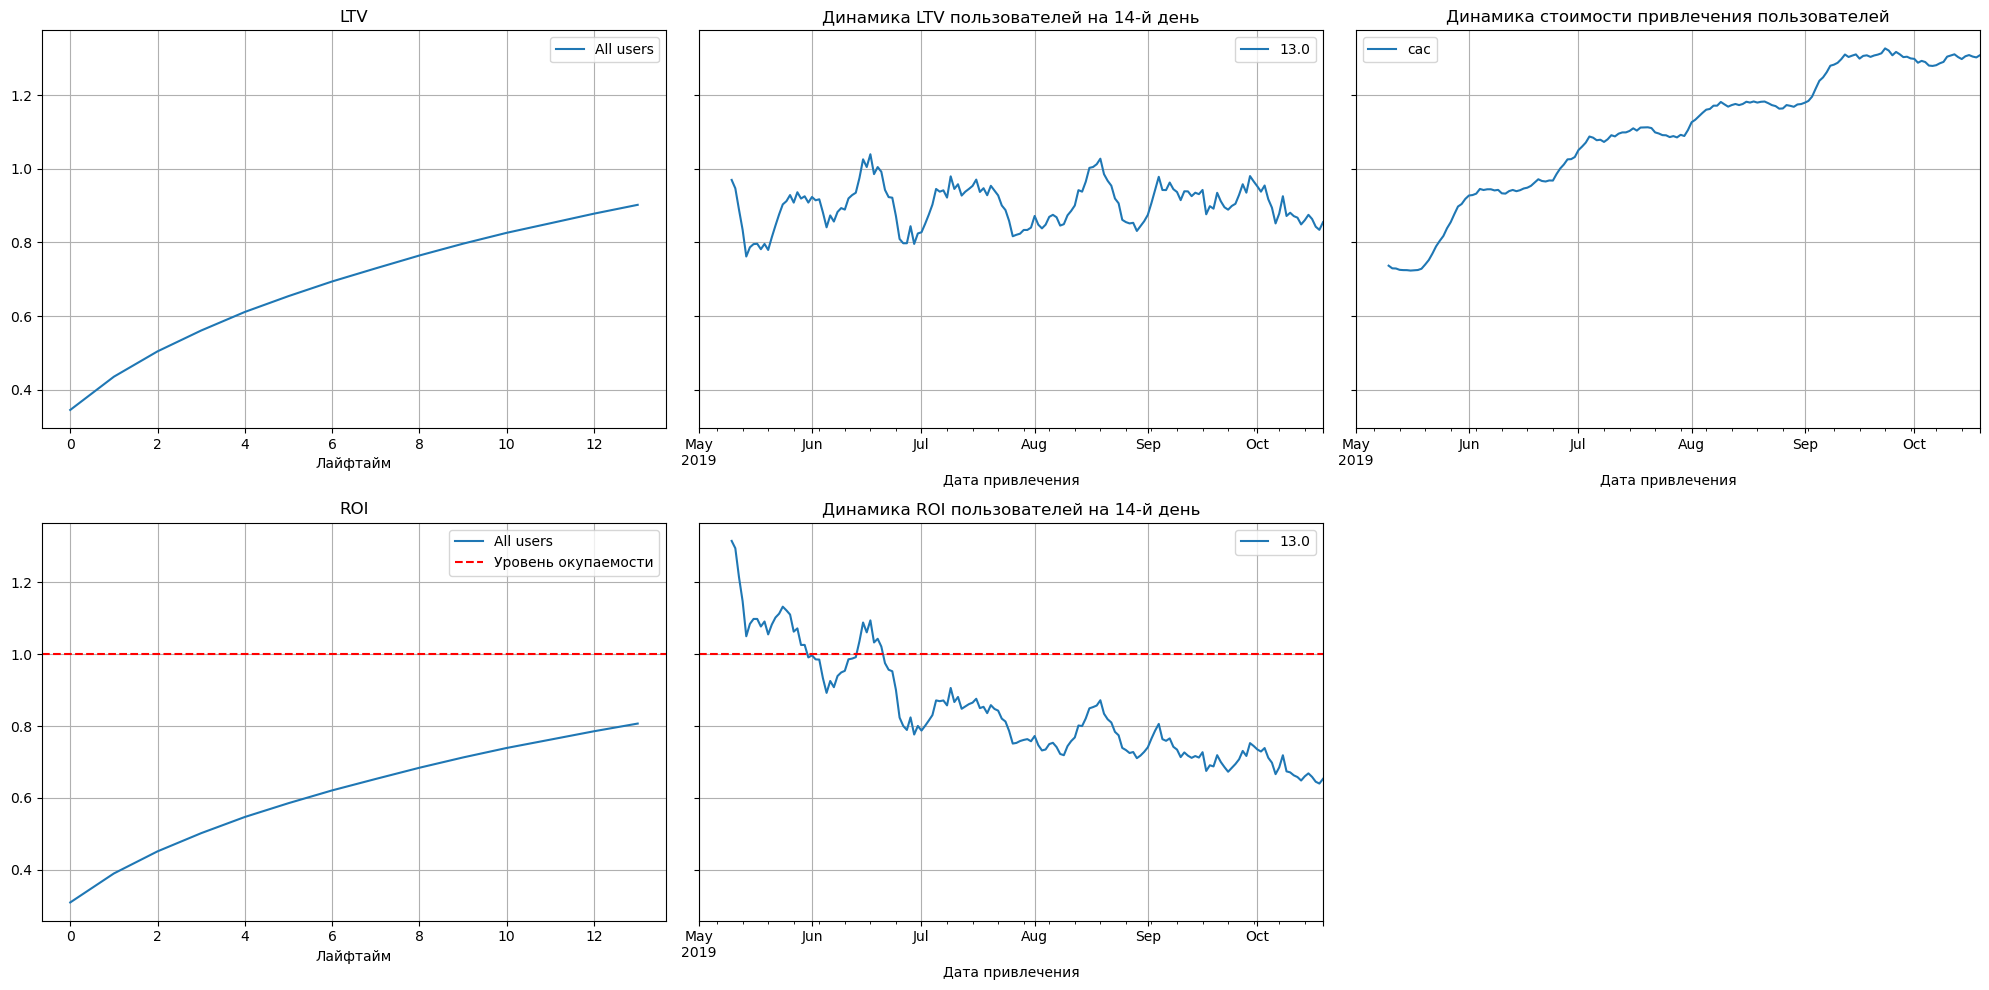

In [45]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, 14, window=10)

Реклама не окупается, с середины июня ROI стала меньше единицы и с тех пор не поднималась выше.  
Стоимость привлечения пользователей постоянно росла. А LTV сильно не менялась, потому компания и столкнулась с тем, что ее реклама не окупается.

#### Конверсия и удержание по странам

Для анализа удержания воспользуюсь функцией `get_retention`, и выберу временной промежуток, в который войдут самые свежие данные за октябрь.

In [46]:
retention_raw, retention, retention_history = get_retention(
    profiles.query('month == 10'), visits, date(2019,11,1), 14, dimensions=['region']
)

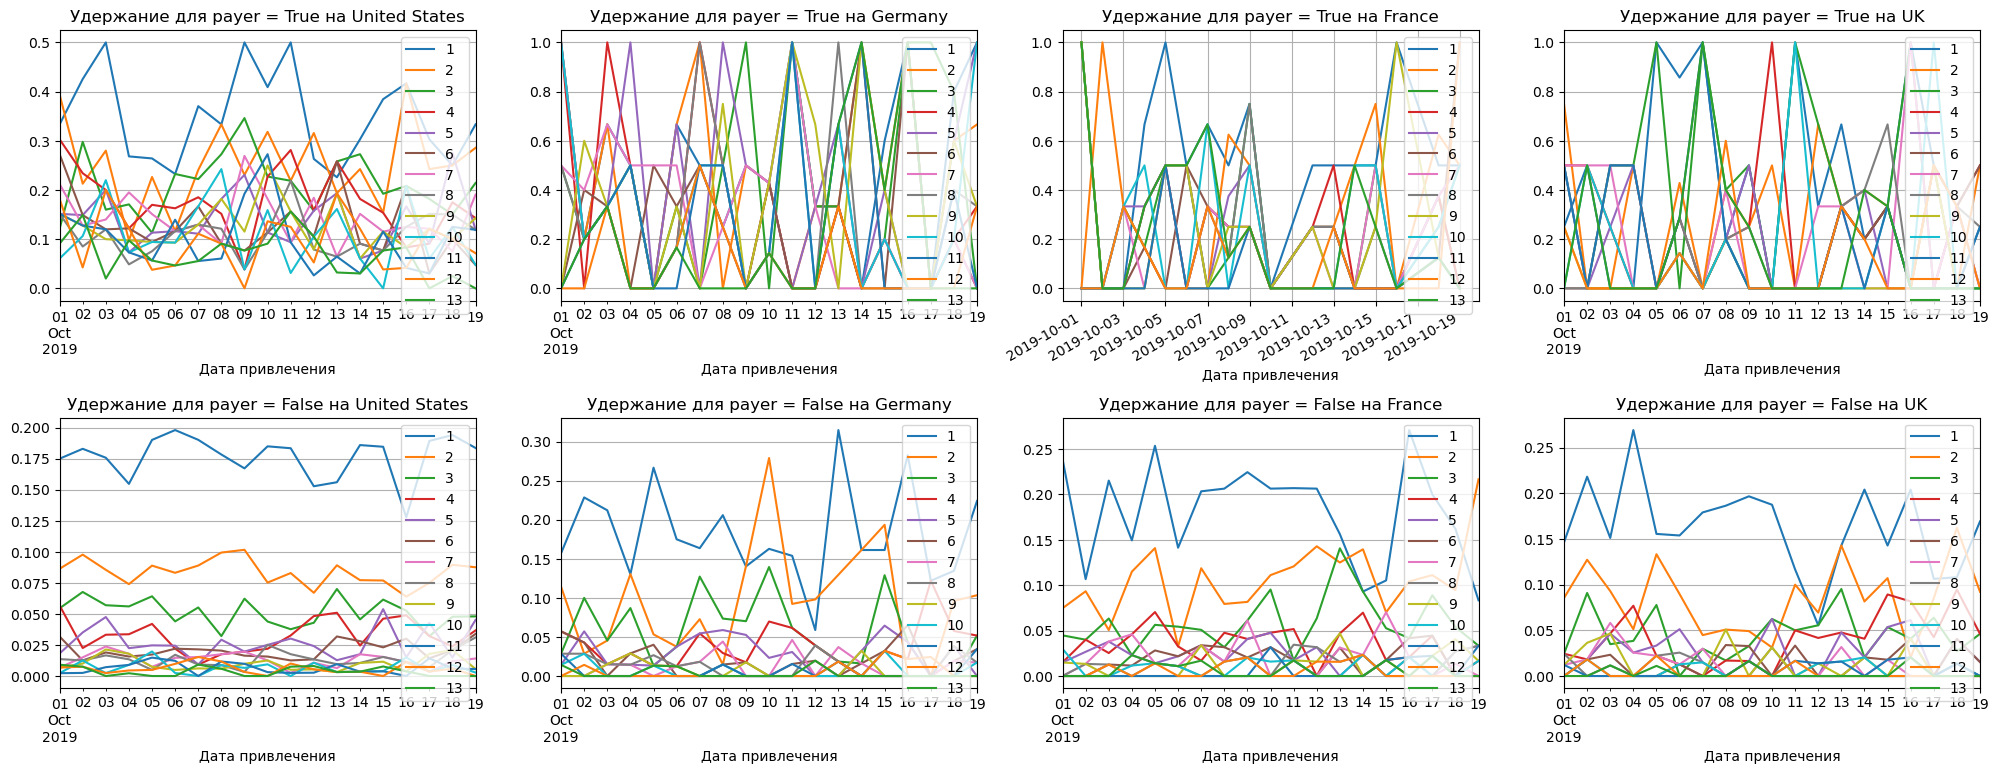

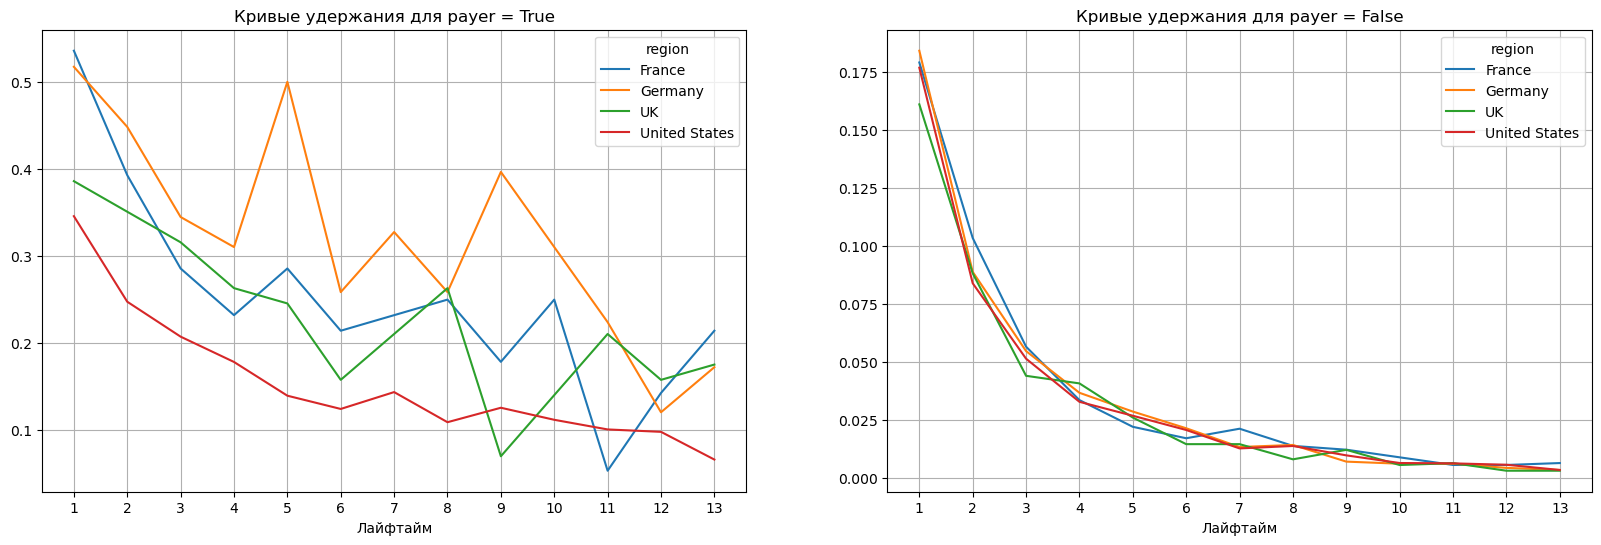

In [47]:
# Графики истории изменений

plt.figure(figsize=(20, 8))

report = retention_history.drop(columns=['cohort_size', 0])

num_rows = len(profiles['payer'].unique())
num_cols = len(profiles['region'].unique())

for i, payer in enumerate(profiles['payer'].unique()):
    for j, region in enumerate(profiles['region'].unique()):
        (
            report.query('payer == @payer and region == @region')
            .droplevel(['payer', 'region'])
            .plot(
                grid=True,
                ax=plt.subplot(num_rows, num_cols, i * num_cols + j + 1),
            )
        )
        plt.xlabel('Дата привлечения')
        plt.title('Удержание для payer = {} на {}'.format(payer, region))
plt.tight_layout()

# График кривых удержания

plt.figure(figsize=(20, 6))

report = retention.drop(columns=['cohort_size', 0])

for i, payer in enumerate(profiles['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1),
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

В первую очередь видно, что удержание платящих пользователей выше, чем неплатящих, как это обычно бывает.  
При этом для неплатящих пользователей удержание слабо отличается в зависимости от страны. К 14 дню удержание незначительно выше у Франции.  
А вот у платящих пользователей ситуация другая. Хотя США - это страна, в которой больше всего пользователей и наивысшая доля плательщиков - удержание там ниже, чем в других странах.  
Намного охотнее продолжают пользоватлся приложением пользователи из Германии и Франции. И у Великобритании удержание на 14-й день выше в два раза, чем в США.

Что насчет **конверсии**?

Сначала изучу общую конверсию.

In [48]:
conv_raw, conv_grouped, conv_in_time = get_conversion(profiles,
                                                      orders,
                                                      date(2019,11,1),
                                                      14)

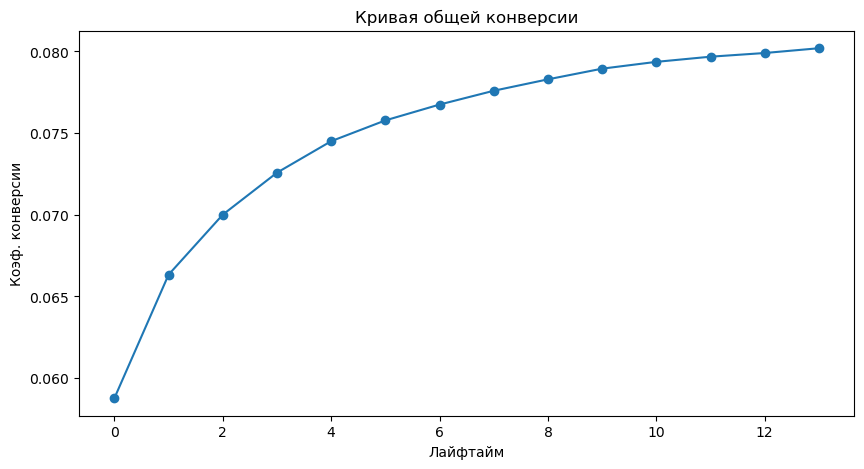

In [49]:
conv_grouped.drop(columns='cohort_size').T.plot(style='o-', figsize=(10,5), legend=False)
plt.title('Кривая общей конверсии')
plt.xlabel('Лайфтайм')
plt.ylabel('Коэф. конверсии');

К 14 дню пользования около 8% пользователей становятся плательщиками. Но это при том, что только начав пользоваться приложением, уже 6% сразу выбирают платный тариф.  
Меняется ли конверсия в зависимости от региона?

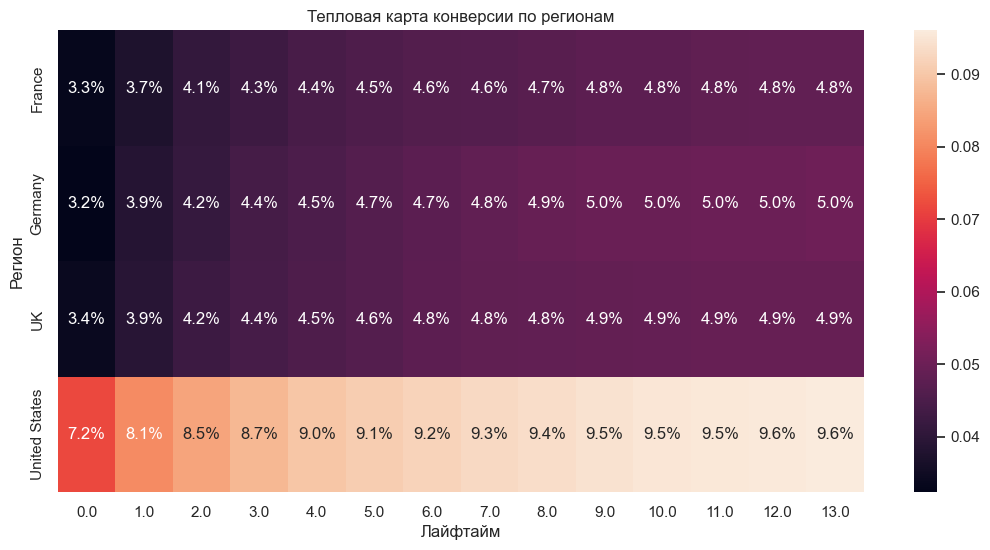

In [50]:
conv_raw, conv_grouped, conv_in_time = get_conversion(profiles,
                                                      orders,
                                                      date(2019,11,1),
                                                      14,
                                                      ['region'])
sns.set(rc = {'figure.figsize':(13,6)})
sns.heatmap(conv_grouped.drop(columns=['cohort_size']), annot=True, fmt='.1%')
plt.title('Тепловая карта конверсии по регионам')
plt.xlabel('Лайфтайм')
plt.ylabel('Регион');

Сильно выделяется регион США. При том, что удержание в этом регионе невысокое, тем не менее намного больше пользователей там готовы платить за пользование приложения. Конверсия в США выше почти в 2 раза по сравнению с европейскими странами. 

#### Конверсия и удержание по устройствам

Посмотрю также на удержание по девайсам.

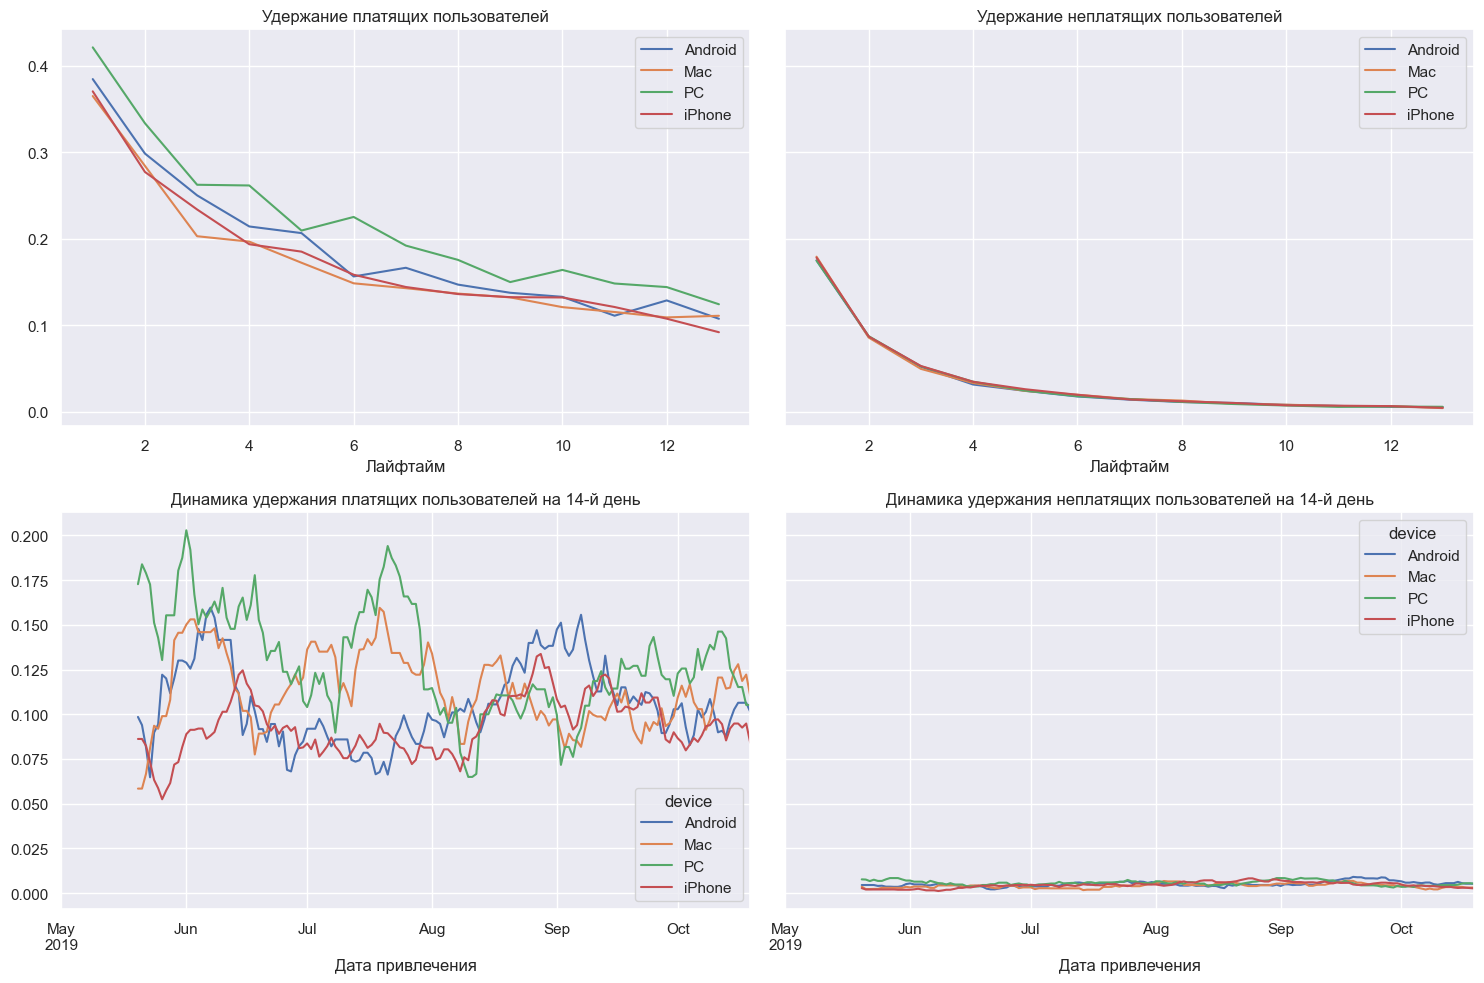

In [51]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, date(2019,11,1), 14, dimensions=['device']
)
plot_retention(retention, retention_history, 14, 20)

Картина для неплатящих пользователей похожа для любого девайса.  
А среди платящих пользователей удержание выше у пользователей ПК. Ниже всего удержание у пользователей iPhone.  
К концу октября удержание всех пользователей снизилось.

In [52]:
conv_raw, conv_grouped, conv_in_time = get_conversion(profiles,
                                                      orders,
                                                      date(2019,11,1),
                                                      14,
                                                      ['device'])

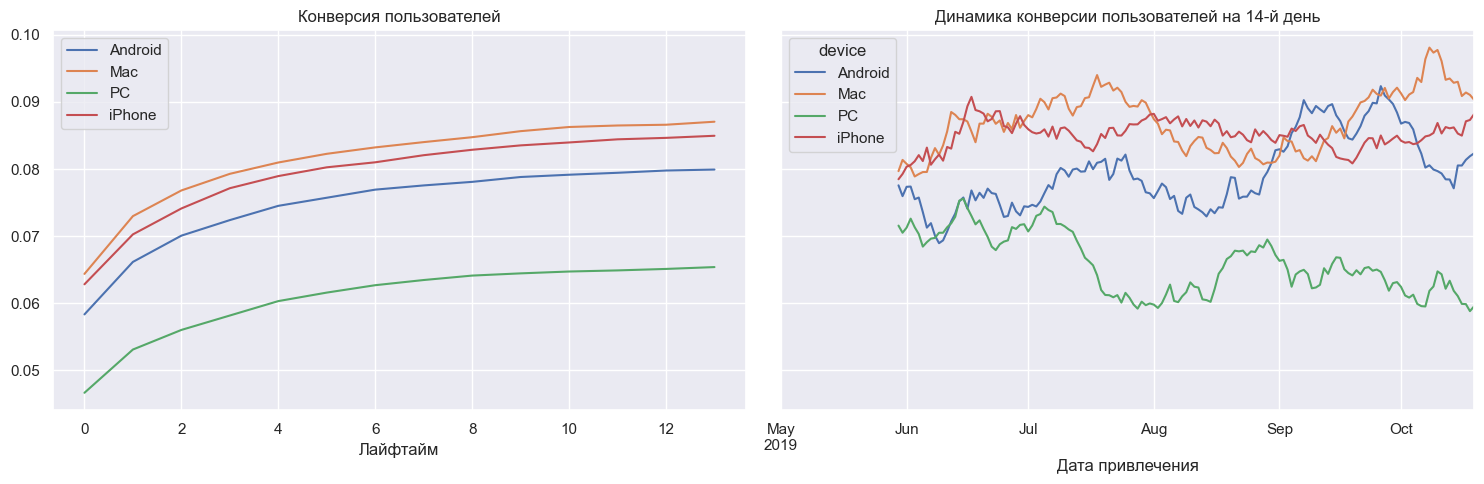

In [53]:
plot_conversion(conv_grouped, conv_in_time, 14, 30)

Наблюдается низкая конверсию у пользователей ПК. Возможно, это связано с тем, что на ПК есть способы обхода приобретения платного тарифа, в таком случае следует проработь систему безопасности и защиты от пиратства. Возможно, по такой же причине конверсия на Android ниже, чем у iPhone.  
Либо же это может быть связано с финансовой состоятельностью пользователей и более высокая конверсия наблюдается у пользователей с более дорогими устройствами.

#### Конверсия и удержание по каналам рекламы

Важно также посмотреть на рекламные каналы, удержание и конверсию по ним.

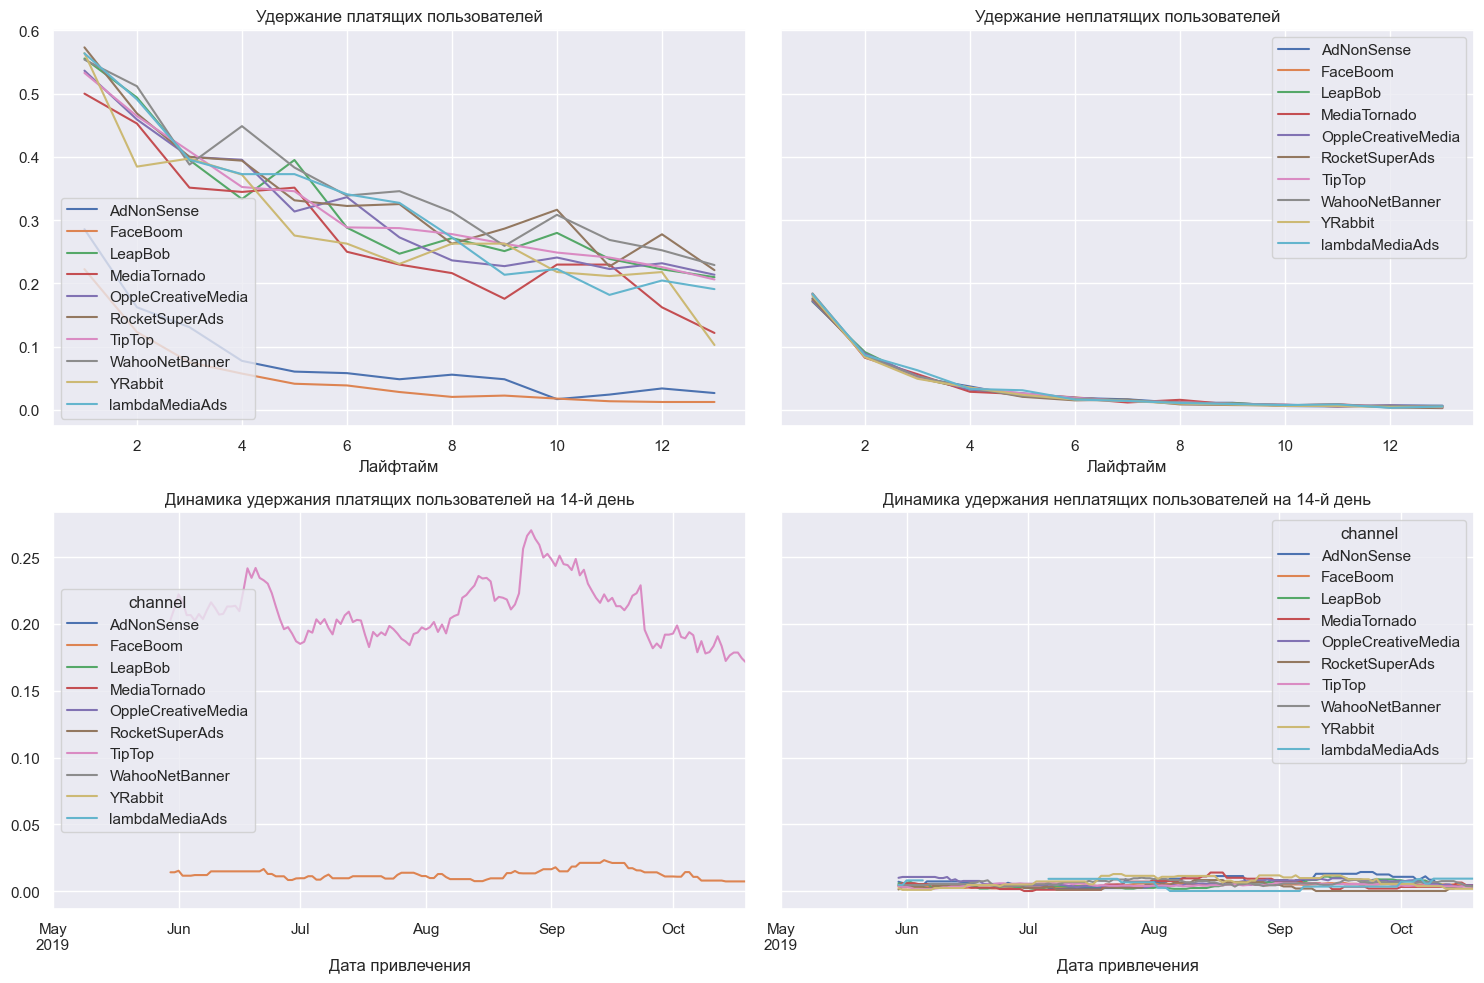

In [54]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, date(2019,11,1), 14, dimensions=['channel']
)
plot_retention(retention, retention_history, 14, 30)

У каналов AdNonSense и FaceBoom удержание значительно ниже, чем у других каналов. И это два канала с самыми высокими тратами на продвижение. Другие каналы почти одинаковы по удержанию, но можно выделить RocketSuperAds, WahooNetBanner и OppleCreativeMedia.

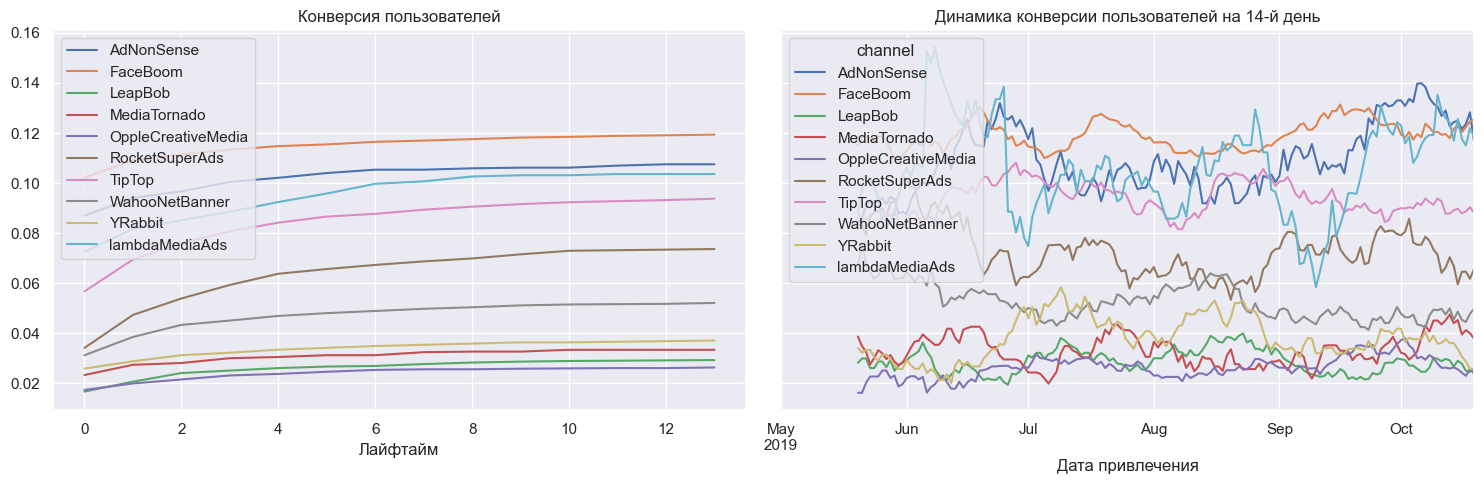

In [55]:
conv_raw, conv_grouped, conv_in_time = get_conversion(profiles,
                                                      orders,
                                                      date(2019,11,1),
                                                      14,
                                                      ['channel'])
plot_conversion(conv_grouped, conv_in_time, 14, window=20)

FaceBoom и AdNonSense обладают самыми высокими показателями конверсии, и раньше было видно, что они приводят наибольшую долю платящих пользователей. Но у этих каналов низкое удержание, поэтому лучше обратить внимание на lambdaMediaAds, TipTop и RocketSuperAds.

#### Окупаемость рекламы по устройствам

Снова воспользуюсь функцией `get_ltv`, чтобы узнать CAC, LTV и ROI в разбивке по устройствам.

In [56]:
 raw_data, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(profiles,
                                                                        orders,
                                                                        date(2019,11,1),
                                                                        14,
                                                                        ['device'])

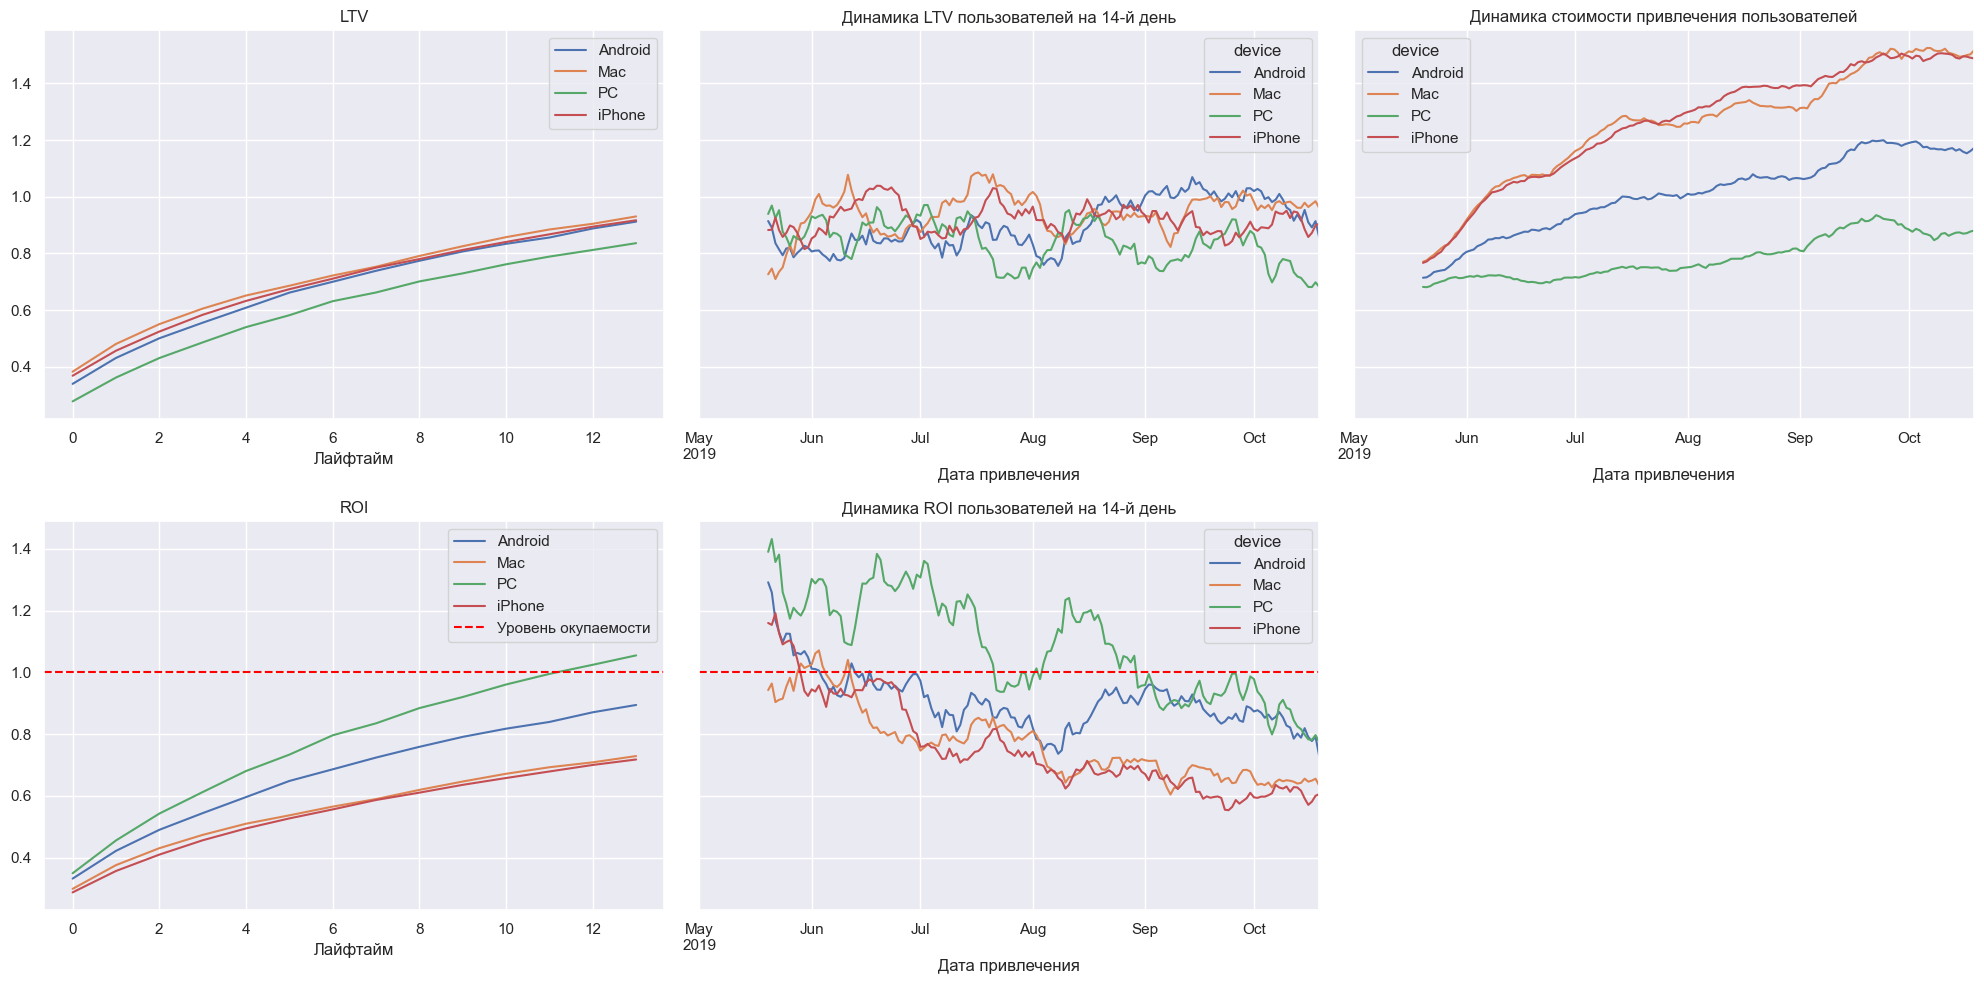

In [57]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, 14, window=20)

Из динамики CAC видно, что значительно выросла стоимость привлечения клиентов, пользующихся iPhone, Mac и Android - она выросла в 1.5 и более раз. Стоимость привлечения пользователей ПК тоже выросла, но не так значительно, поэтому этой платформе все же удается окупиться, хоть и на 11 день.

#### Окупаемость рекламы по странам

In [58]:
 raw_data, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(profiles,
                                                                        orders,
                                                                        date(2019,11,1),
                                                                        14,
                                                                        ['region'])

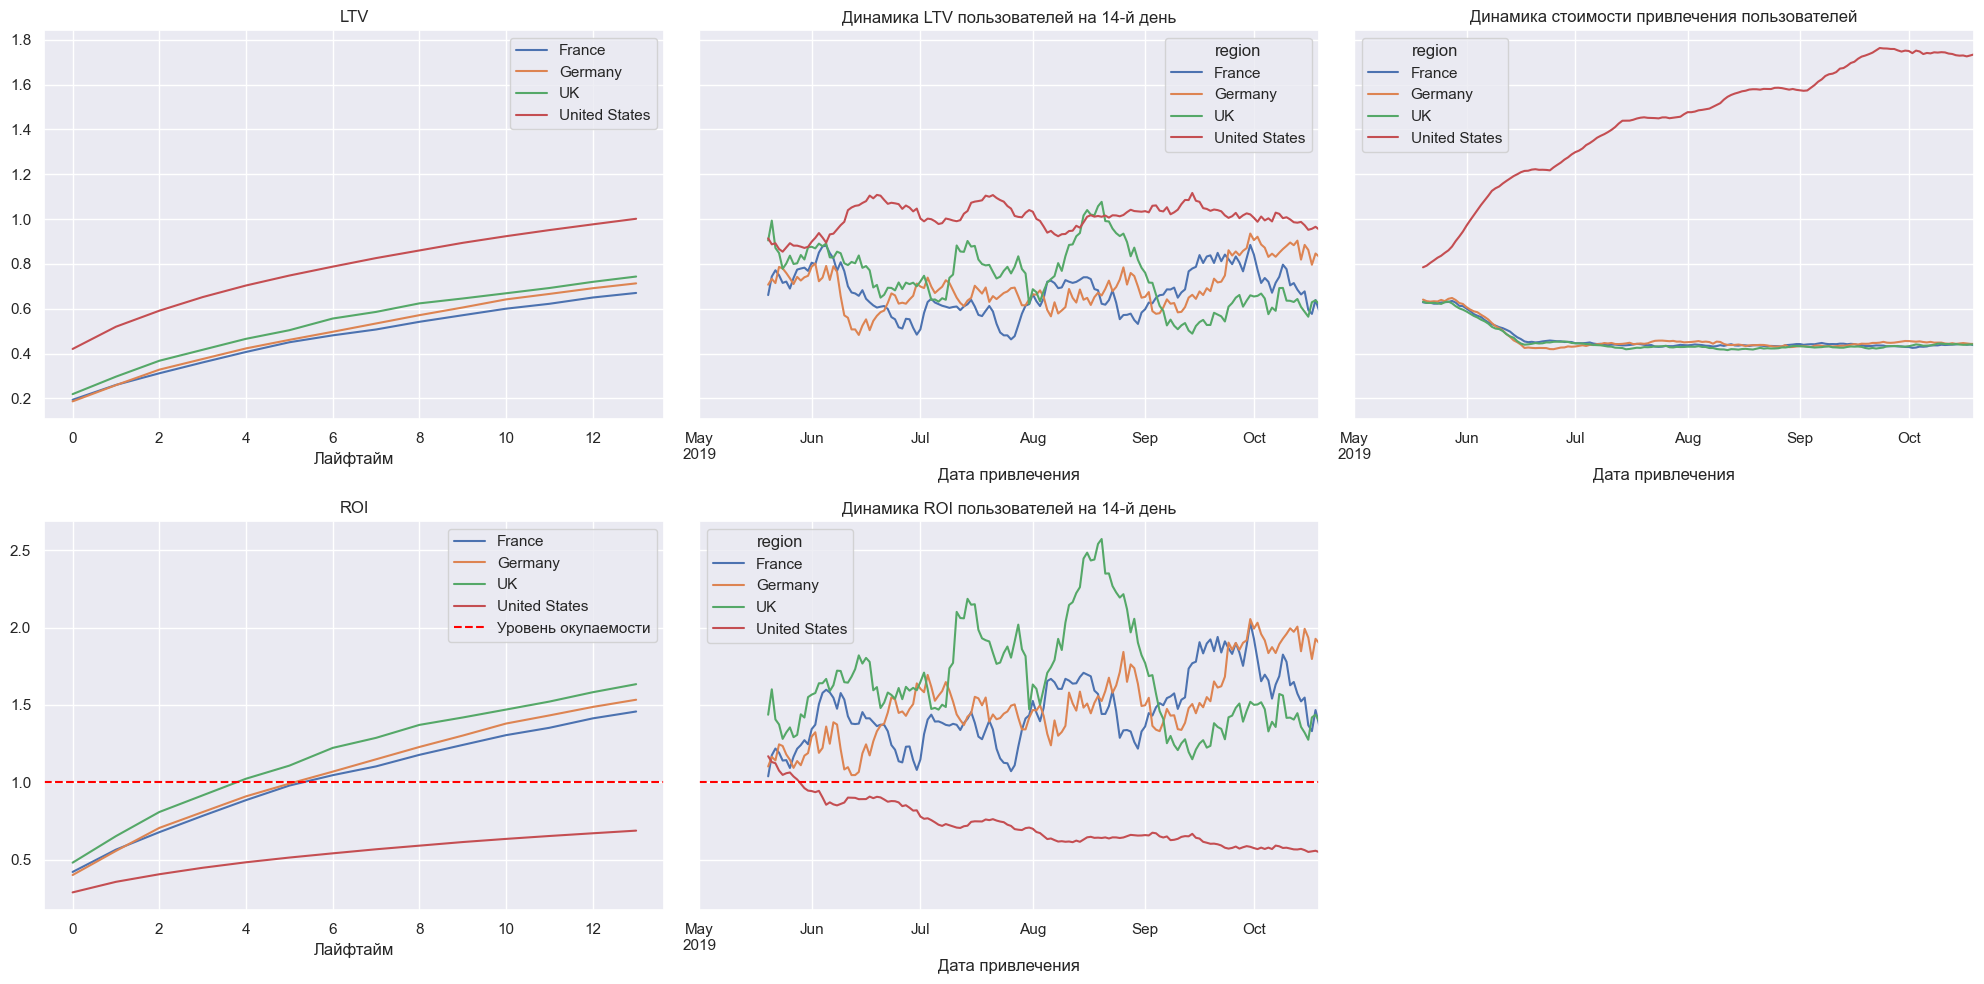

In [60]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, 14, window=20)

Динамика LTV показывает позитивную картину - она стабильна или растет, но вот динамика CAC для США резко возрастает от 0.6 в мае до 1.7 в октябре. В связи с этим пользователи из США не выходят на окупаемость.  
В то время как когорты из Великобритания окупаются на 4 день, из Франции и Германии на 6-й день.  
Кажется, что с европейскими странами все в порядке, и проблема с окупаемостью рекламы кроется как раз в стране, где больше всего клиентов - в США.

#### Окупаемость рекламы по каналам

In [61]:
raw_data, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(profiles,
                                                                        orders,
                                                                        date(2019,11,1),
                                                                        14,
                                                                        ['channel'])

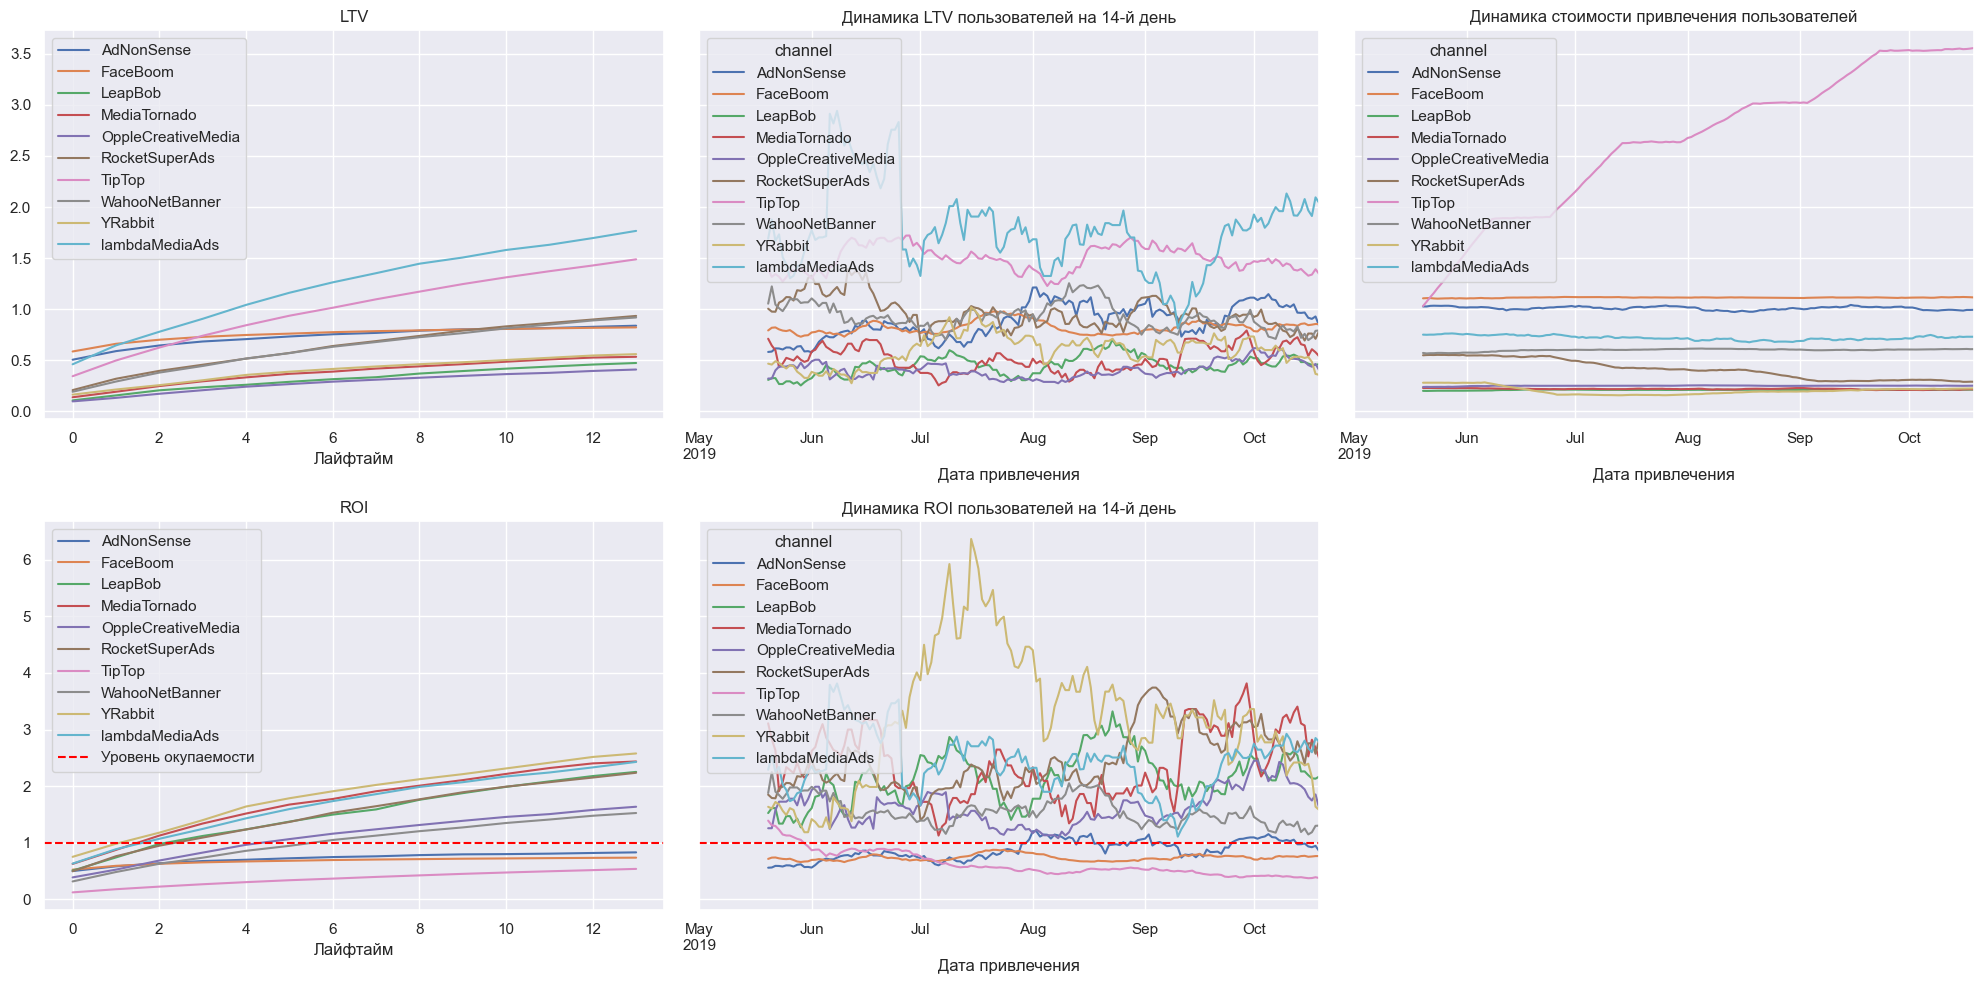

In [62]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, 14, window=20)

Из LTV пользователей лидеры - lambdaMediaAds, TipTop и RocketSuperAds. TipTop - это лидер по рекламным расходам. А lambdaMediaAds, которые показывают лучшие показатели, входит в топ-3 самых мало-финансируемых рекламных каналов.  
Чрезвычайный рост CAC наблюдается для канала TipTop от 0.9 до 3.5 - рост почти в 4 раза.

Посмотрю отдельно ROI каналов по лайфтаймам.

In [63]:
pd.DataFrame(roi_grouped.drop(columns=['cohort_size', 'cac', 0, 1])
            ).style.background_gradient('BuGn').format('{:.2f}')

Есть множество рекламных каналов, которые имеют ROI больше единицы.  
Лидеры рекламных затрат: TipTop (топ-1), FaceBoom (топ-2) и AdNonSense (топ-4) - не окупаются.  
В то время как каналы, которые финансируются меньше всех показывают как лучшее удержание, так и хорошую окупаемость.

Топ каналов по окупаемости:  
1. YRabbit
2. lambdaMediaAds (+высокая конверсия)
3. MediaTornado
4. LeapBob
5. RocketSuperAds

#### Вывод оценки окупаемости рекламы

Реклама не окупается с середины июня. Стоимость привлечения пользователей постоянно росла. А LTV сильно не менялась, потому компания и столкнулась с тем, что ее реклама не окупается. 

*Конверсия и удержание по странам:* Самое низкое удержание у США, из европейских стран выделяется Германия.  
Однако конверсия у США в 2 раза больше, чем у других стран (9.6% против 4.9%)

*Конверсия и удержание по устройствам:* Удержание слабо зависит от устройства, но самое высокое удержание наблюдается у пользователей ПК. В конверсии же это не совпадает. У ПК низкая конверсия (максимум 6.5% к 14 дню), самая высокая у Mac (8.7%), iPhone близок к Mac с конверсией в 8.5%, у Android 8%.

*Конверсия и удержание по каналам:* У каналов AdNonSense и FaceBoom удержание значительно ниже, чем у других каналов. И это два канала с самыми высокими тратами на продвижение. Другие каналы почти одинаковы по удержанию, но можно выделить RocketSuperAds, WahooNetBanner и OppleCreativeMedia. FaceBoom и AdNonSense обладают самыми высокими показателями конверсии, и раньше было видно, что они приводят наибольшую долю платящих пользователей. Но у этих каналов низкое удержание, поэтому лучше обратить внимание на lambdaMediaAds, TipTop и RocketSuperAds.

*Окупаемость рекламы по устройствам:* Из динамики CAC видно, что значительно выросла стоимость привлечения клиентов, пользующихся iPhone, Mac и Android - она выросла в 1.5 и более раз. FaceBoom и AdNonSense обладают самыми высокими показателями конверсии, и раньше было видно, что они приводят наибольшую долю платящих пользователей. Но у этих каналов низкое удержание, поэтому лучше обратить внимание на lambdaMediaAds, TipTop и RocketSuperAds.

*Окупаемость рекламы по странам:* CAC для США резко возрастает от 0.6 в мае до 1.7 в октябре. Пользователи из США не окупаются.

*Окупаемость рекламы по каналам:* Из LTV пользователей лидеры - lambdaMediaAds, TipTop и RocketSuperAds. TipTop - это лидер по рекламным расходам. Его CAC выросла почти в 4 раза до $3.5. Топ каналов по рекламным расходам - не окупаются. Наилучшую окупаемость демонстрируют каналы с наименьшим финансированием.

### Вывод

В ходе работы проанализированы рекламные мероприятия приложения.  
Анализ был разделен на несколько этапов, напишу выводы по каждому из них.

**Исследовательский анализ**  
С мая рекламные расходы выросли в два раза, а количество новых пользователей осталось прежним.

*Географическое распределение:* больше всего пользователей - в США (100 тыс.) с 6.9% плательщиков. Примерно в 6 раз меньше пользователей в Германии, Великобритании и Франции. Плательщиков там тоже меньше. По 4.11%, 3.98% и 3.80% соответственно.  

*Распределение по девайсам:* больше всего пользователей iPhone (54 тыс.) с 6.21% плательщиков. Платформой Android пользуется 35 тыс. пользователей с 5.85% пользователей. По 30 тыс. пользователей на платформах Mac и PC с 6.36% и 5.05% плательщиков соответственно.

*Распределение по каналам:* 38% пользователей - органические. Остальные приходят из разных рекламных каналов. Больше всего из FaceBoom и TipTop. По проценту привлеченных платящих пользователей топ-5 выглядит следующим образом: FaceBoom (12.2%), AdNonSense (11.3%), lambdaMediaAds (10.5%), TipTop (9.6%), RocketSuperAds (7.9%)

**Маркетинг**  
Топ рекламных каналов по вложеным средствам: TipTop, FaceBoom, WahooNetBanner, AdNonSense, OppleCreativeMedia.  
Расходы постоянно растут. Например, с июня к сентябрю расходы по TipTop вырорсли в два раза. При том, что этот канал - самый дорогой по CAC ($2.8). Чуть больше доллара CAC также у FaceBoom и AdNonSense.  

**Оценка окупаемости рекламы**  
Общая CAC показывает постоянный рост. От 0.65 долл. в июне до 0.85 в октябре.  
Общая LTV достигает только $0.9 к 14 дню пользования.  
Реклама не окупается с середины июня, CAC превышает LTV.

*Конверсия и удержание по устройствам:* Удержание слабо зависит от устройства, но самое высокое удержание наблюдается у пользователей ПК. В конверсии же это не совпадает. У ПК низкая конверсия (максимум 6.5% к 14 дню), самая высокая у Mac (8.7%), iPhone близок к Mac с конверсией в 8.5%, у Android 8%.

*Конверсия и удержание по каналам:* У каналов AdNonSense и FaceBoom удержание значительно ниже, чем у других каналов. И это два канала с самыми высокими тратами на продвижение.  
Другие каналы почти одинаковы по удержанию, но можно выделить RocketSuperAds, WahooNetBanner и OppleCreativeMedia. FaceBoom и AdNonSense обладают самыми высокими показателями конверсии, и раньше было видно, что они приводят наибольшую долю платящих пользователей. Но у этих каналов низкое удержание, поэтому лучше обратить внимание на lambdaMediaAds, TipTop и RocketSuperAds.

*Окупаемость рекламы по устройствам*  
Из динамики CAC видно, что значительно выросла стоимость привлечения клиентов, пользующихся iPhone, Mac и Android - она выросла в 1.5 и более раз.  
К 10 дню окупаются инвестиции, направленные на пользователей Android и Mac. Позже, к 12 дню окупаются траты на пользователей iPhone. А вот пользователи ПК, несмотря на то, что это лидеры по удержанию - не окупаются.

*Окупаемость рекламы по странам*  
CAC для США резко возрастает от 0.6 в мае до 1.7 в октябре. Когорты из США не окупаются, в то время как когорты из Великобритания окупаются на 4 день, из Франции и Германии на 6-й день.

*Окупаемость рекламы по каналам*  
Из LTV пользователей лидеры - lambdaMediaAds, TipTop и AdNonSense. TipTop - это лидер по рекламным расходам, но его CAC с мая по октябрь выросла от 0.9 до 3.5. Ведущие по рекламным затратам каналы - не окупаются.
Топ каналов по окупаемости:  
1. YRabbit
2. lambdaMediaAds (+высокая конверсия)
3. MediaTornado
4. LeapBob
5. RocketSuperAds

**Рекомендации бизнесу**  
В первую очередь стоит пересмотреть приоритетность рекламных каналов. Стоит сфокусироваться на тех, которые окупаются (YRabbit, lambdaMediaAds, MediaTornado и другие). Из топ-5 каналов по затратам тут не представлено ни одного.  
AdNonSence и FaceBoom, которые входили в топ-3 финансируемых каналов не окупаются, но и кроме того показывают низкое удержание и конверсию. TipTop же - лидер по расходам показывает неплохую удержание, но чересчур высокую CAC.  

Стоит обратить внимание и на устройства. ПК показывает низкую конверсию, но высокое удержание. Возможно, существуют варианы обхода платного тарифа на ПК или для этой платформы предоставляется расширенный функционал, что не побуждает пользователей приобретать платный тариф.

Дополнительно компания может поработать над увеличением удержания в США, так как это страна с наибольшей аудиторией, от которой во многом зависит финансовое положение компании. Так как в случае, если рынок насытится, и удержание станет еще меньше - вероятны убытки. Либо же компания может переориентироваться на другие рынки, которые показывают как высокую окупаемость, так и удержание.